# **Recap**: Region-based CNNs

Region-based convolutional neural networks are commonly used for detecting objects in images, both using bounding boxes and segmentation masks. In this section, we'll recap how these networks work, starting from the base R-CNN model going all the way up to Mask R-CNN. Each model improves and builds upon the last.

The model most widely used is Faster R-CNN nowadays: however, providing an overview of the base R-CNN provides insights into Faster R-CNN and enables a better understanding of the architecture.

## R-CNN

Rather than being a "single" model, R-CNN is actually an ensemble of different models, whose outputs are combined together to form the final prediction.

### Architecture

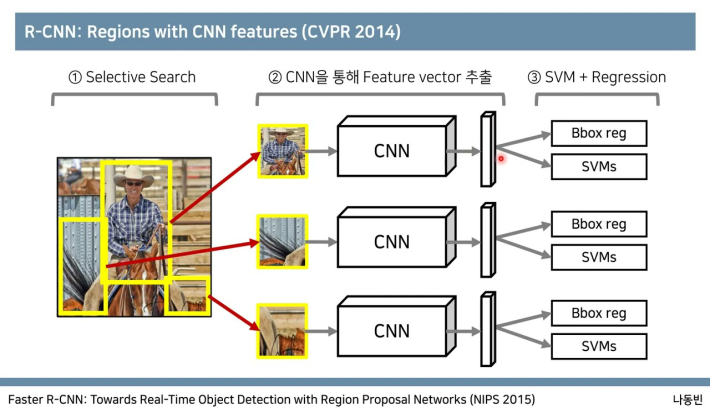

### Phase 1: Selective Search

R-CNN starts by applying selective search, a Computer Vision algorithm, on the original image. As a result, a total of circa 2000 **Regions of Interest (RoI)** are extracted: A RoI is no more than just a rectangular portion of the image where an object could be located. At this stage, the class of the object is still unknown.

Each RoI is assigned one and only one label, based on its overlap with ground truth bounding boxes. If the **IoU (Intersection over Union)** metric is above a certain threshold, then it is assigned that class, else it is labeled as background.

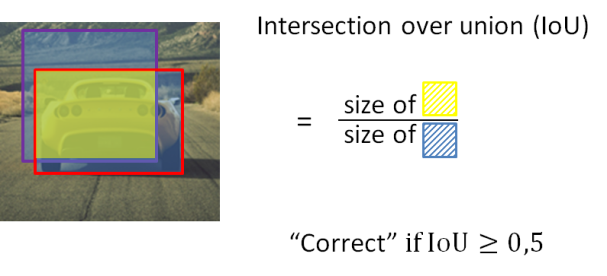

The blue square represents the RoI, while the yellow square represents the ground truth: since there is a significant overlap, the region is labeled as "Car".

### Phase 2: Extracting RoI features via a CNN

Each of these regions is now warped to fit the input size of a pre-trained CNN (called "**backbone**"). 

Let $k$ be the number of our classes: dog, cat, etc.

The labeled, warped regions constitute a fine-tuning classification dataset for the backbone, so that it becomes able to extract relevant features that make a car a car, a person a person, a dog a dog, and so on. The CNN needs to be fine-tuned to recognize background images as well, so it is effectively trained on $k+1$ classes. 

After fine-tuning, the CNN is deprived of its softmax layer, so that the 4096-d feature vector is used to subsequently train other models in Phase 3.

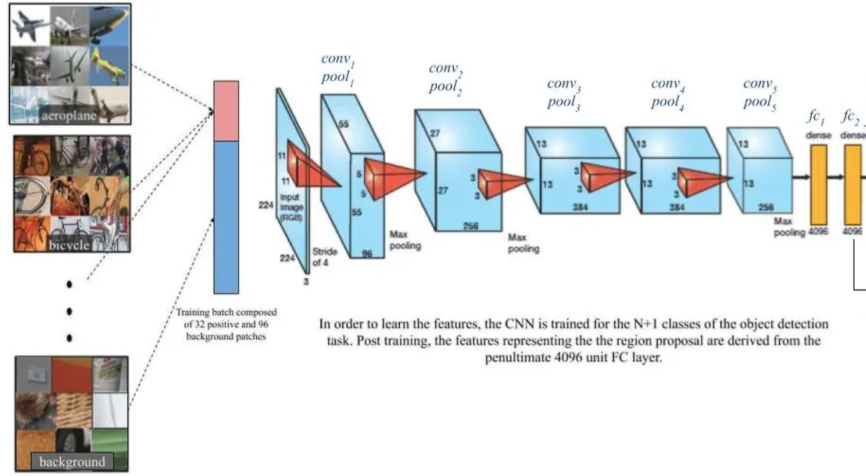

### Phase 3

#### SVMs

In this phase, we will instantiate $k$ SVMs, and the $i$-th SVM will be trained to distinguish background regions from regions containing class $i$. 
 
Say we have three classes (cat, dog, bird): we then create three SVMs. 
The first SVM receives a mixture of: 

```[Data = feature vectors containing cats, Label = cats]```

```[Data = feature vectors containing background, Label = background]```

The second SVM receives a mixture of: 

```[Data = feature vectors containing dogs, Label = dogs]```

```[Data = feature vectors containing background, Label = background]```

The third SVM receives a mixture of: 

```[Data = feature vectors containing birds, Label = bird]```

```[Data = feature vectors containing background, Label = background]```

At inference time, for a certain region, it will give out a certain probability of having object of class $i$ in there. 

#### Bounding Box Regression

In parallel, there's another model, which is a regressor. 

This is what it takes in input:

```[Data = feature vector of a RoI encoding a non-background region]```

```Coord_1 = bounding box coordinates obtained by Selective Search for the same RoI```

```Coord_2 = ground-truth box coordinates for the object contained in the RoI```

```Final Label = geometric transformation between Coord_1 and Coord_2```

The goal of the bounding box regressor is to learn the needed offsets to transform the proposed bounding box to the ground truth bounding box. This transformation involves adjusting the coordinates and dimensions of the proposed bounding box to better fit the object.

### Phase 4: Non-Maximum Suppression

For a single object, R-CNN might predict more than one bounding box, each with different probabilities.

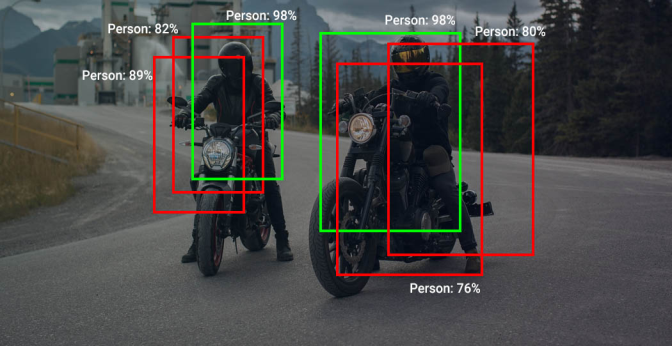

This is how NMS is used to obtain the most likely candidate:

Non-Maximum Suppression (NMS) is an essential post-processing step in object detection algorithms, including R-CNN and Fast R-CNN. Its primary role is to eliminate redundant bounding boxes and retain only the most likely ones for each object. Here's how it works and an example of its application:


1. **Initial Detection**:
   - The system initially detects multiple bounding boxes around each person. Due to variations in the detection algorithm, some persons might have multiple boxes around them, while others have just one.

2. **Applying NMS**:
   - NMS begins by discarding boxes with very low confidence scores (e.g., a box covering an empty space mistakenly identified as a person).
   - It then selects the box with the highest confidence score (say, around a particular person).
   - The IoU of this box with other boxes is calculated. Boxes covering the same car, indicated by high IoU values, are suppressed.
   - This process continues until all people are accounted for with the most appropriate bounding box.

3. **Result**:
   - The final output is a clean set of bounding boxes, each accurately surrounding a single person, with no unnecessary overlaps.

In this example, NMS plays a crucial role in ensuring that each person is detected precisely once, despite the initial over-detection.

## Fast R-CNN

Looking through the R-CNN learning steps, you could easily find out that training an R-CNN model is expensive and slow, as the following steps involve a lot of work:

- Running selective search to propose 2000 region candidates for every image
- Generating the CNN feature vector for every image region (N images * 2000)
- The whole process involves three models separately without much shared computation: 
    - The convolutional neural network for feature extraction 
    - The top SVM classifier for identifying target objects
    - The regression model for tightening region bounding boxes.

Fast R-CNN overcomes this by proposing a different architecture.

### Architecture

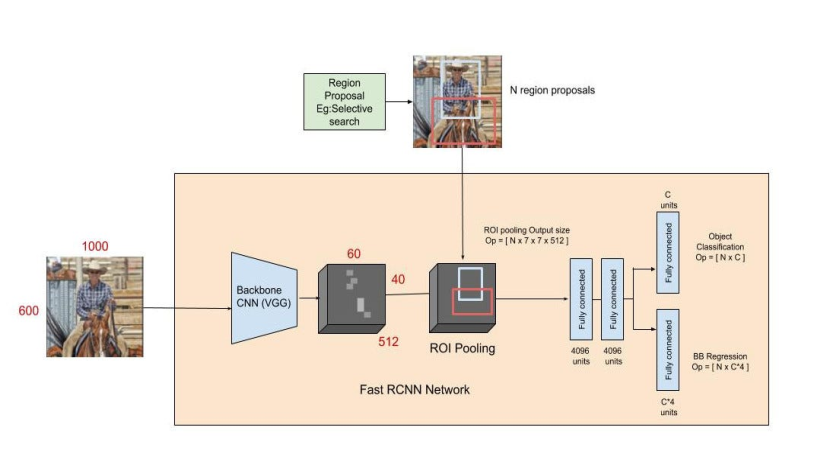

### Steps

Unlike R-CNN, which consisted of three separate stages, Fast R-CNN is end-to-end trainable.

1. **Feature Map Extraction**: Fast R-CNN starts with passing the original image through a CNN backbone, obtaining a single, multidimensional feature map. 

2. **Selective Search**: After convoluting the image, Selective Search generates region proposals based on the original image in the exact same manner as base R-CNN. 

3. **RoI Projection**:
For each RoI, a corresponding region of the feature map is identified via a process called RoI projection. This step ensures that the spatial information of the original RoIs is preserved when projecting the region on the convolved image.

4. **RoI Pooling**:
These RoIs need to be passed through a multi-objective network that, for each region, obtains the label of the object and the coordinate of the bounding box. However, the multi-objective network has a fixed-size input requirement, and different RoIs may vary in size. So, each of these RoI projections (which are nothing more than cropped portions of the feature map) are then passed through a RoI pooling layer. 
The RoI pooling layer takes a RoI in input, then divides it into subregions. Each subregion is max-pooled. 

5. **Classification and Regression Network**:
The output shape of the RoI Pooling layer meets the input shape of the multi-objective network. Each RoI is passed through two FC layers, which constitute the "shared" base of the network. Then, the network branches into two different **heads**, which respectively tackle the role that SVMs and Regressors had in R-CNN. This network is evaluated using a multi-objective loss.
    - The classification branch receives a feature vector as data, and its class as label.
    - The regression branch receives the same feature vector, but receives the bounding box transformation as label.

### Usage

Fast R-CNN models are seldom trained from scratch. 

- These models use very strongly pre-trained backbones, such as VGG16, which see tens of thousands of images and classes. Thus, when you use a VGG16 backbone trained on datasets like ImageNet (featuring cats, dogs, etc.), the model has learned a wide variety of features, from basic edges and textures to more complex shapes.

- Say that you want to train the Fast R-CNN model on your custom dataset of handwritten digits on white sheets of paper. The task of the network is to identify where digits lie on the sheet of paper, and assign them a class.
- You don't necessarily need the VGG16 backbone to understand signatures specifically from the outset. What's important is the rich feature representation it has learned. When you fine-tune Fast R-CNN on your signature dataset, you freeze some layers and train others.
    - The initial layers of the VGG16, which capture basic features, may not change much, but the deeper layers, which capture more specific features, will adjust significantly to better suit signature recognition.

## Faster R-CNN

### Architecture

Faster R-CNN builds on Fast R-CNN by replacing the Selective Search algorithm with a Region Proposal Network.

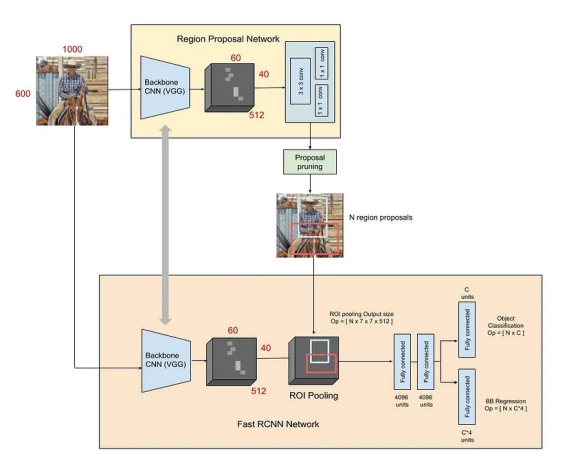

### Region Proposal Network

The Region Proposal Network (RPN) works like so:

1. Get a CNN backbone trained for image classification.

2. Fine-tune the RPN (region proposal network) end-to-end for the region proposal task, using the backbone obtained in step 1. 

    - Positive samples have IoU (intersection-over-union) > 0.7, while negative samples have IoU < 0.3.

3. Slide a small $n\times n$ spatial window over the conv feature map of the entire image. At the center of each sliding window, we predict multiple regions of various scales and ratios simultaneously. 

    - An anchor is a combination of (sliding window center, scale, ratio). For example, 3 scales + 3 ratios => $k = 9$ anchors at each sliding position.

4. Prune proposals via NMS.

### Inference

Bounding box coordinates are then re-mapped to the original image when performing inference.

## Mask R-CNN

### Architecture

Based on the framework of Faster R-CNN, Mask R-CNN adds a third branch for predicting an object mask in parallel with the existing branches for classification and localization. 

The mask branch is a small fully-connected network applied to each RoI, predicting a segmentation mask in a pixel-to-pixel manner.

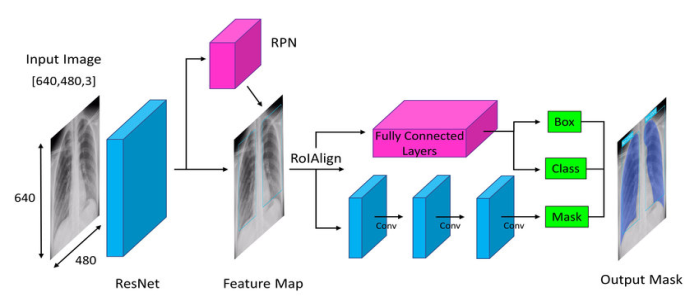

**Layer output**:

For each RoI, Mask R-CNN predicts a class label and a bounding box offset. Then, it generates a binary mask of dimension for each class. During inference, the model selects the mask corresponding to the predicted class. If multiple objects of different classes are present, the mask for the highest-scoring class is typically chosen.

However, the RPN often proposes RoIs that align closely with individual object instances rather than groups of objects. 

### Loss Function(s)

The loss function of Mask R-CNN is a multi-task loss, combining different components to train the network for both object detection and instance segmentation. It extends the loss function used in Faster R-CNN by adding a loss term for mask prediction. The overall loss $ L $ in Mask R-CNN is given by:

$ L = L_{cls} + L_{box} + L_{mask} $

1. **Classification Loss ($ L_{cls} $)**: This is the loss for the object classification task. It's a categorical cross-entropy loss between the predicted class probabilities and the ground-truth class labels for each RoI.

2. **Bounding Box Regression Loss ($ L_{box} $)**: This is the loss for the bounding box regression task. It uses a Smooth L1 loss between the predicted bounding box offsets and the ground-truth bounding box offsets. The Smooth L1 loss is less sensitive to outliers than MSE and is typically used in object detection tasks.

3. **Mask Prediction Loss ($ L_{mask} $))**: This is the additional loss term introduced in Mask R-CNN for the segmentation mask prediction.

    - It's calculated by first passing all pixels of the mask through a sigmoid, which outputs, for each pixel, the [0, 1] probability of the object belonging to a class or to the background. Then, Binary Cross-Entropy loss is used.

    - Importantly, this loss is only computed on the class-specific mask of the ground truth class for each RoI, not across all classes. 
    
        - This means for a given RoI, if the ground truth class is "cat", the loss is calculated between the predicted mask for "cat" and the ground truth mask, ignoring the mask predictions for other classes.


### Inference

Masks are then re-mapped to the original image when performing inference.

# Mask R-CNN Fine-tuning

## Data Exploration

### Mask example

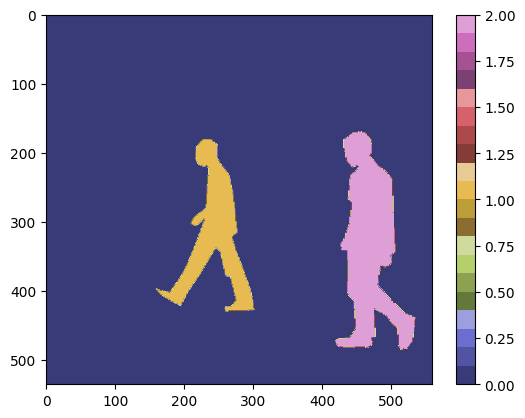

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# Load the mask
mask = Image.open('/kaggle/input/pennfudan/PennFudanPed/PedMasks/FudanPed00001_mask.png')
mask = np.array(mask)

# Visualize the mask
plt.imshow(mask, cmap='tab20b') # needed because the mask is not 0-255 but 0-2
plt.colorbar()
plt.show()

In [ ]:
mask.shape

(536, 559)

### Image example

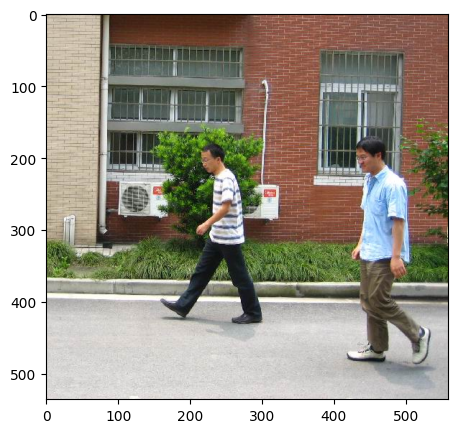

In [ ]:
from torchvision.io import read_image

image = read_image("/kaggle/input/pennfudan/PennFudanPed/PNGImages/FudanPed00001.png")

plt.figure(figsize=(10, 5))
plt.imshow(image.permute(1, 2, 0)) # from (3, 530, 660) to (530, 660, 3) because of matplotlib

### Bounding Box example

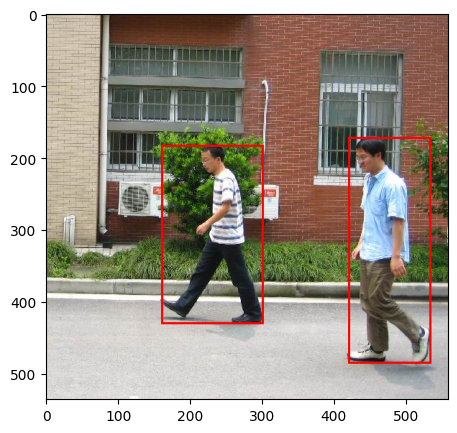

In [ ]:
from PIL import ImageDraw
import re
import torchvision.transforms.functional as F

with open("/kaggle/input/pennfudan/PennFudanPed/Annotation/FudanPed00001.txt", "r") as f:
    label_text = f.read()

# Get boxes
pattern = r'Bounding box for object \d+ "PASpersonWalking" \(Xmin, Ymin\) - \(Xmax, Ymax\) : \((\d+), (\d+)\) - \((\d+), (\d+)\)'
matches = re.findall(pattern, label_text)
boxes = []
for xmin, ymin, xmax, ymax in matches:
    boxes.append((int(xmin), int(ymin), int(xmax), int(ymax)))

# Draw boxes on image
pil_image = F.to_pil_image(image)
draw = ImageDraw.Draw(pil_image)
for box in boxes:
    draw.rectangle(box, outline="red", width=3)

plt.figure(figsize=(10, 5))
plt.imshow(pil_image)

### Define Torch Datasets

In [ ]:
import torch
from torchvision import transforms as T

class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, images, masks):
        # Memorize arrays of image and mask names
        self.imgs = images
        self.masks = masks

    def __getitem__(self , idx):
        img = Image.open("/kaggle/input/pennfudan/PennFudanPed/PNGImages/" + self.imgs[idx]).convert("RGB")
        mask = Image.open("/kaggle/input/pennfudan/PennFudanPed/PedMasks/" + self.masks[idx])

        # From PIL to Numpy array
        mask = np.array(mask)
        # STEP 1: Get number of instances (minus the background)
        obj_ids = np.unique(mask)[:1]
        num_objs = len(obj_ids)

        # STEP 2: Generate a different boolean mask for each instance.
        # If a 640x480 mask contains 3 instances, masks will be shaped (3, 640, 480)
        masks = np.zeros((num_objs, mask.shape[0], mask.shape[1]))
        for i in range(num_objs):
            # Get all cells of the matrix where the value is i + 1 in a True/False form
            object_mask = mask == i + 1
            # Get current mask
            current_mask = masks[i]
            # Set all cells where the value is i + 1 to True.
            current_mask[object_mask] = True

        # STEP 3: For each boolean mask (so, for each object), generate a bounding box.
        boxes = []
        for i in range(num_objs):
            # Get positions of True elements.
            y_true, x_true = np.where(masks[i])
            # Get leftmost position of true pixel
            xmin = np.min(x_true)
            # Get rightmost position of true pixel
            xmax = np.max(x_true)
            # Get lowest position of true pixel
            ymin = np.min(y_true)
            # Get highest position of true pixel
            ymax = np.max(y_true)
            boxes.append([xmin, ymin, xmax, ymax])

        masks = torch.as_tensor(masks, dtype=torch.uint8)
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.ones((num_objs,), dtype=torch.int64)

        # STEP 4: package it all
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        return T.ToTensor()(img), target

    def __len__(self):
        return len(self.imgs)

## Modeling

### Instantiate Dataloaders

Typically, the DataLoader's default collate function tries to stack all tensors in a batch along a new dimension (the batch dimension). This requires all tensors in the batch to have the same shape, which isn't the case with our image tensors of different sizes, leading to the RuntimeError if leaving the default collate.

By defining *custom_collate*, we're bypassing this behavior. The DataLoader now returns each batch as a list of data items (tuples of image and target) without trying to stack or merge them. This works because there's no longer an attempt to unify different tensor sizes into a single batch tensor.

In [ ]:
def collate_fn_custom(batch):
    return batch

In [ ]:
import os
from sklearn.model_selection import train_test_split

# Load image and mask names
images = sorted(os.listdir("/kaggle/input/pennfudan/PennFudanPed/PNGImages"))
masks = sorted(os.listdir("/kaggle/input/pennfudan/PennFudanPed/PedMasks"))
train_imgs, val_imgs, train_masks, val_masks = train_test_split(images, masks, test_size=0.1, random_state=42)

# Instantiate dataloaders
train_dl = torch.utils.data.DataLoader(PennFudanDataset(train_imgs, train_masks),
                                batch_size = 2,
                                shuffle = True,
                                collate_fn = collate_fn_custom,
                                num_workers = 1,
                                pin_memory = True if torch.cuda.is_available() else False) # non copia su cuda ma ottimizza il processo quando poi tu vai a fare to device

val_dl = torch.utils.data.DataLoader(PennFudanDataset(val_imgs, val_masks),
                                batch_size = 2,
                                shuffle = True,
                                num_workers = 1,
                                collate_fn = collate_fn_custom,
                                pin_memory = True if torch.cuda.is_available() else False)


### Defining the model

To fine-tune the Mask R-CNN model, we essentially re-train the two outermost layers, the heads. We create two blank instances of mask and box predictors, and attach those to the existing network, eliminating the pre-trained heads.

In [ ]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

# Instantiating a pre-trained Mask R-CNN with a ResNet50 backbone
model = torchvision.models.detection.maskrcnn_resnet50_fpn()

# Get input dimensions for the classification and masking heads.
# This is so that our blank heads input dimensions match the previous layers' outputs.
# This is also to have the correct number of features in output.
in_features = model.roi_heads.box_predictor.cls_score.in_features
in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels

# Create a blank box predictor (includes classification)
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, 2)
# Create a blank mask predictor
hidden_layer = 256
model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, hidden_layer, 2)

Move it to the GPU

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu):

### Optimizer

In [ ]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)

### Training Loop

In [ ]:
all_train_losses = []
all_val_losses = []
model.train()

for epoch in range(15):
    print(f'##### Epoch: {epoch} #####')
    train_epoch_loss = 0
    val_epoch_loss = 0

    for _, batch in enumerate(train_dl):

        imgs_device = [batch[i][0].to(device) for i in range(len(batch))]
        labels = [batch[i][1] for i in range(len(batch))]

        labels_device = [{} for _ in range(len(batch))]
        for idx, label in enumerate(labels):
            for k, v in label.items():
                labels_device[idx][k] = v.to(device)

        # Print the loss
        loss = model(imgs_device, labels_device)
        losses = sum([l for l in loss.values()])
        train_epoch_loss += losses.cpu().detach().numpy()

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

    print('Training metrics:')
    for k, v in loss.items():
        if k not in ['loss_objectness', 'loss_rpn_box_reg']:
            print(f'{k}: {v.item():.2f}', end=' | ')
    all_train_losses.append(train_epoch_loss)
    print(f'total_loss: {train_epoch_loss}')

    with torch.no_grad():
        for _, batch in enumerate(val_dl):

            imgs_device = [batch[i][0].to(device) for i in range(len(batch))]
            labels = [batch[i][1] for i in range(len(batch))]

            labels_device = [{} for _ in range(len(batch))]
            for idx, label in enumerate(labels):
                for k, v in label.items():
                    labels_device[idx][k] = v.to(device)


            loss = model(imgs_device, labels_device)
            losses = sum([l for l in loss.values()])
            val_epoch_loss += losses.cpu().detach().numpy()

        print('Validation metrics:')
        for k, v in loss.items():
            if k not in ['loss_objectness', 'loss_rpn_box_reg']:
                print(f'{k}: {v.item():.2f}', end=' | ')
        print(f'total_loss: {val_epoch_loss}')

        all_val_losses.append(val_epoch_loss)

##### Epoch: 0 #####
Training metrics:
loss_classifier: 0.04 | loss_box_reg: 0.04 | loss_mask: 0.63 | total_loss: 76.90508186817169
Validation metrics:
loss_classifier: 0.06 | loss_box_reg: 0.07 | loss_mask: 0.54 | total_loss: 6.624186336994171
##### Epoch: 1 #####
Training metrics:
loss_classifier: 0.03 | loss_box_reg: 0.02 | loss_mask: 0.51 | total_loss: 54.17521971464157
Validation metrics:
loss_classifier: 0.04 | loss_box_reg: 0.03 | loss_mask: 0.73 | total_loss: 6.076247692108154
##### Epoch: 2 #####
Training metrics:
loss_classifier: 0.04 | loss_box_reg: 0.06 | loss_mask: 0.32 | total_loss: 41.6056153178215
Validation metrics:
loss_classifier: 0.05 | loss_box_reg: 0.04 | loss_mask: 0.49 | total_loss: 4.321817189455032
##### Epoch: 3 #####
Training metrics:
loss_classifier: 0.06 | loss_box_reg: 0.10 | loss_mask: 0.27 | total_loss: 34.40105006098747
Validation metrics:
loss_classifier: 0.06 | loss_box_reg: 0.07 | loss_mask: 0.30 | total_loss: 3.877845585346222
##### Epoch: 4 #####


### Check metrics

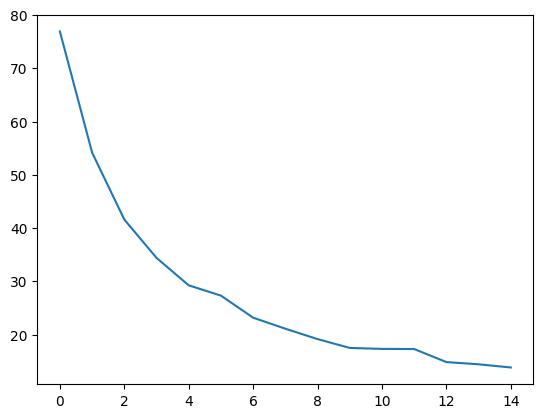

In [ ]:
plt.plot(all_train_losses)

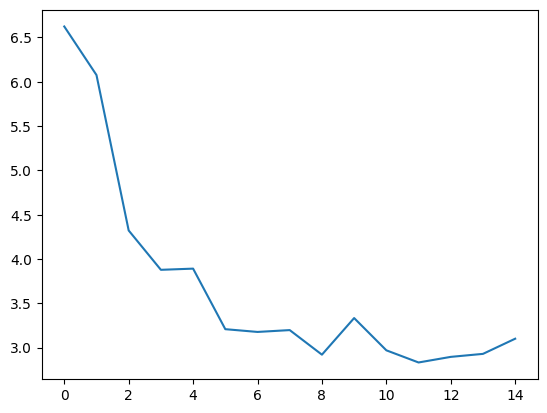

In [ ]:
plt.plot(all_val_losses)

## Inference

In [ ]:
!wget https://cdn.pixabay.com/photo/2018/09/18/21/08/couple-3687274_960_720.jpg

--2024-01-30 17:04:53--  https://cdn.pixabay.com/photo/2018/09/18/21/08/couple-3687274_960_720.jpg
Resolving cdn.pixabay.com (cdn.pixabay.com)... 172.64.147.160, 104.18.40.96, 2606:4700:4400::ac40:93a0, ...
Connecting to cdn.pixabay.com (cdn.pixabay.com)|172.64.147.160|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 206784 (202K) [binary/octet-stream]
Saving to: 'couple-3687274_960_720.jpg.1'

couple-3687274_960_ 100%[===================>] 201.94K  --.-KB/s    in 0.03s   

2024-01-30 17:04:53 (7.85 MB/s) - 'couple-3687274_960_720.jpg.1' saved [206784/206784]



In [ ]:
model.eval()
img = Image.open("/kaggle/working/couple-3687274_960_720.jpg")
transform = T.ToTensor()
ig = transform(img)
with torch.no_grad():
    pred = model([ig.to(device)])

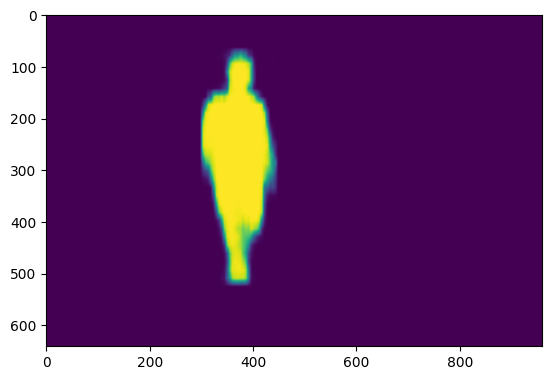

In [ ]:
plt.imshow((pred[0]["masks"][0].cpu().detach().numpy() * 255).astype("uint8").squeeze())